# Results

In [2]:
%load_ext autoreload
%autoreload 2

Running diagnostics...
DIAGNOSTIC INFORMATION
Found 24 YAML files

SAMPLE AGENT NAMES FROM FILES:
  - selfdiscovery_temp_1.0_max_iter_1_llm_llama-3.1-8b-instruct_dataset_financial_a6dd6d9f.yaml: agent_name = self_discovery
  - selfdiscovery_temp_1.0_max_iter_1_llm_llama-3.1-8b-instruct_dataset_eligibility_5c24484d.yaml: agent_name = self_discovery
  - react_temp_1.0_max_iter_1_llm_llama-3.1-8b-instruct_dataset_eligibility_48014243.yaml: agent_name = react
  - reflection_temp_1.0_max_iter_1_llm_llama-3.1-8b-instruct_dataset_healthcare_42cb6f9e.yaml: agent_name = reflection
  - reflection_temp_1.0_max_iter_1_llm_llama-3.1-8b-instruct_dataset_eligibility_f44d19e0.yaml: agent_name = reflection

LOADED DATAFRAME AGENT COLUMN:
  - Unique agent values: ['self_discovery' 'react' 'reflection' 'slow' 'fast' 'tot' 'improver'
 'plan_execute']
  - Count: 8
  - Example rows:
    * selfdiscovery_temp_1.0_max_iter_1_llm_llama-3.1-8b-instruct_dataset_financial_a6dd6d9f.yaml -> agent = self_discovery
  

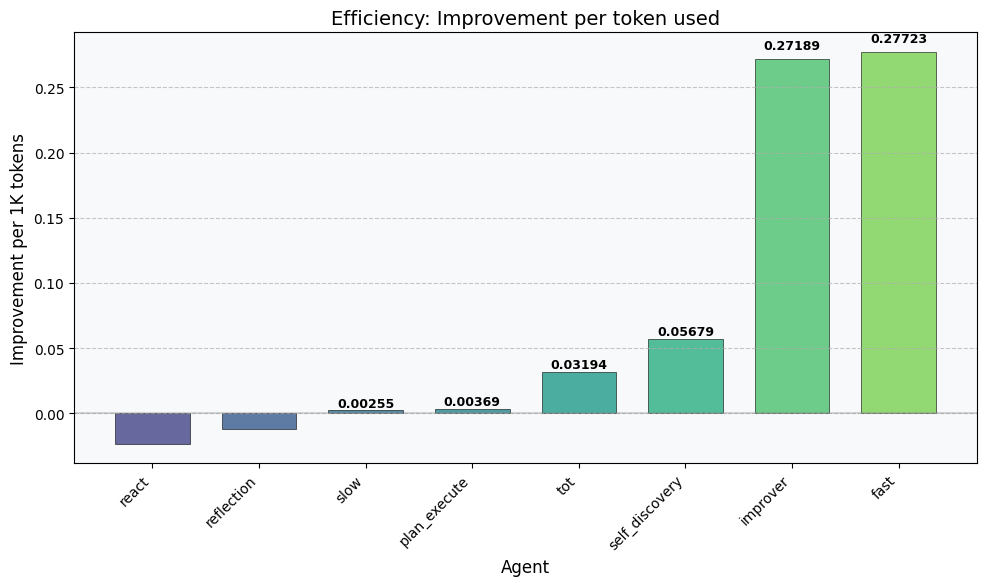

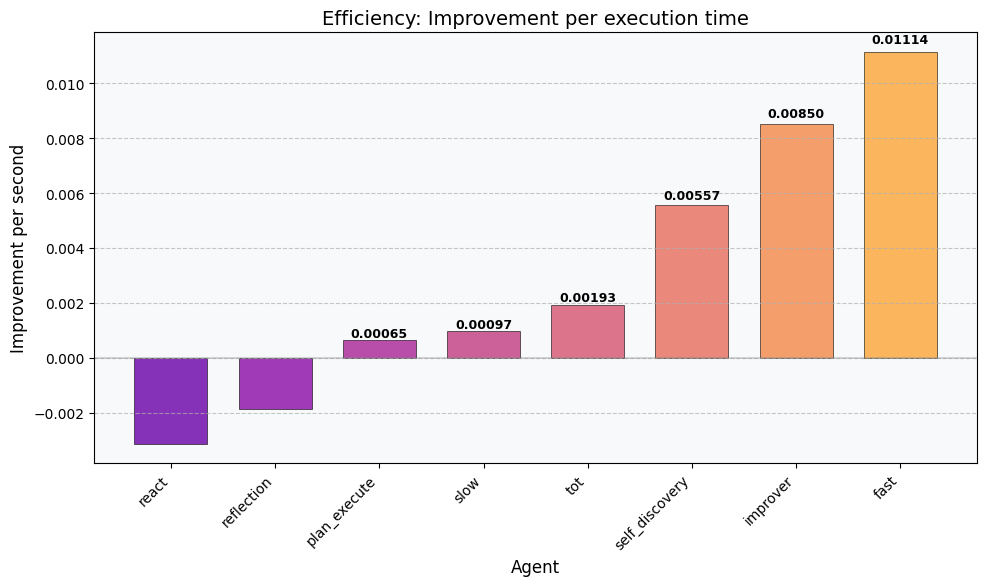

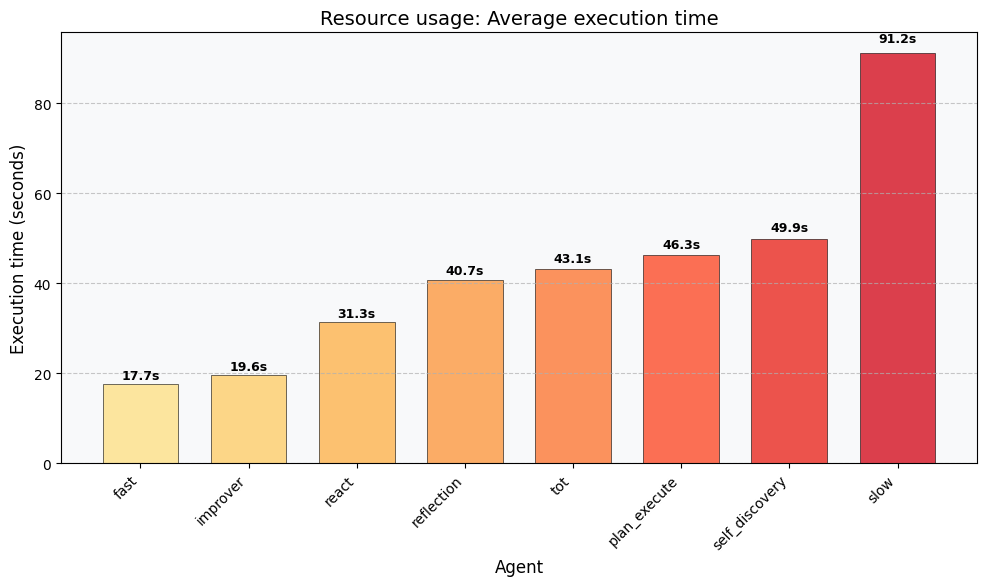

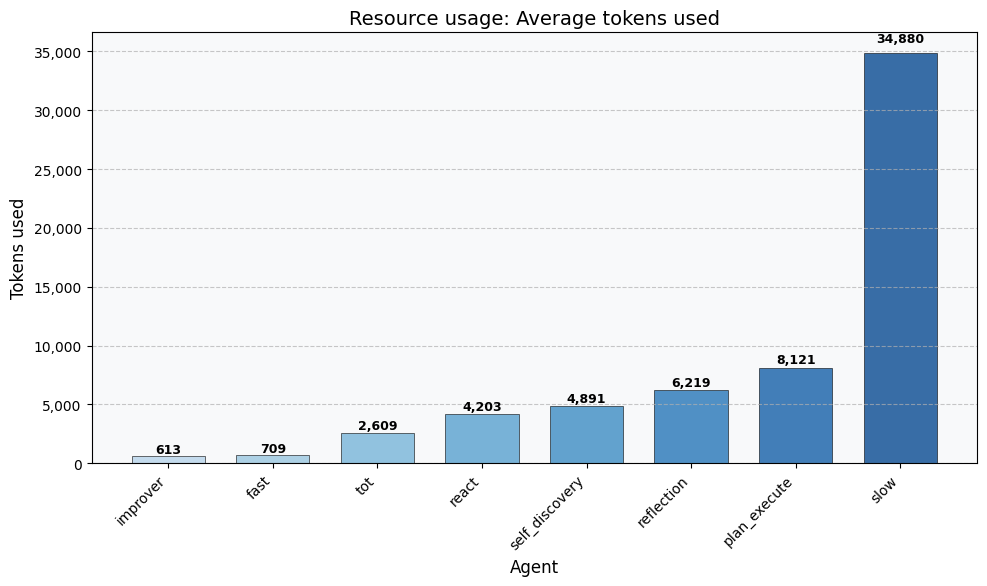

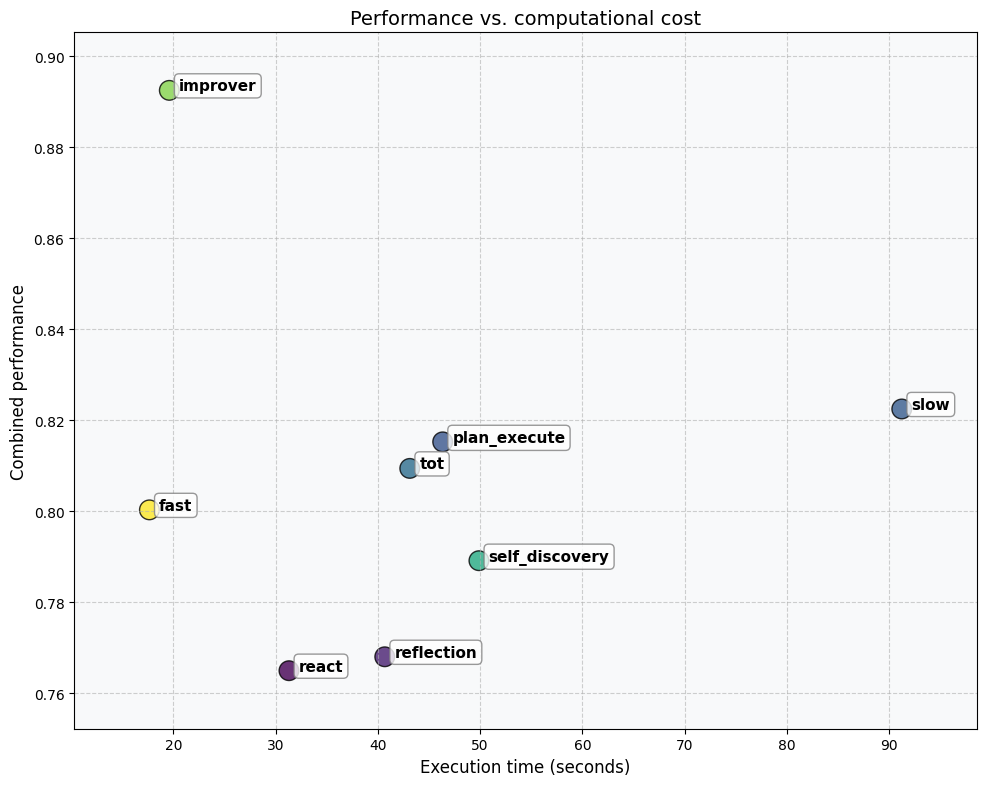


Analysis complete!

Detailed run-level results summary:
       temperature  max_iter  initial_new  final_new  initial_old  final_old  \
count    24.000000      24.0    22.000000  24.000000    22.000000  24.000000   
mean      0.895833       1.0     0.682879   0.767764     0.727424   0.832444   
std       0.294115       0.0     0.230608   0.103266     0.257635   0.074962   
min       0.000000       1.0     0.000000   0.500000     0.000000   0.633333   
25%       1.000000       1.0     0.716667   0.716667     0.658333   0.791667   
50%       1.000000       1.0     0.716667   0.800000     0.783333   0.867500   
75%       1.000000       1.0     0.783333   0.833333     0.913333   0.880417   
max       1.000000       1.0     0.860000   0.883333     0.913333   0.922000   

       improvement_new  improvement_old  generalization_gap_initial  \
count        22.000000        22.000000                   22.000000   
mean          0.086500         0.105697                    0.044545   
std      

In [2]:
import os
import glob
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
import warnings

# Set up publication-ready styling
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

# Set a more modern color palette
COLORS = sns.color_palette("viridis", 10)
FIGURE_DPI = 300

def load_results(results_dir: str = "results") -> pd.DataFrame:
    """
    Load YAML files from the specified directory and extract key evaluation metrics and parameters.

    Parameters
    ----------
    results_dir : str
        Directory containing YAML result files

    Returns
    -------
    pd.DataFrame
        DataFrame with processed results
    """
    files = glob.glob(os.path.join(results_dir, "*.yaml"))
    records = []
    
    for file in files:
        with open(file, "r") as f:
            try:
                data = yaml.safe_load(f)
            except Exception as e:
                warnings.warn(f"Failed to load {file}: {e}")
                continue
                
        # Parse parameters from the filename using regex
        basename = os.path.basename(file)
        pattern = r"^(.*?)_temp_([0-9.]+)_max_iter_(\d+)_llm_([^_]+)_dataset_([^_]+)_.*\.yaml$"
        match = re.match(pattern, basename)
        
        if match:
            agent_from_fname = match.group(1)
            temperature = float(match.group(2))
            max_iter = int(match.group(3))
            llm = match.group(4)
            dataset = match.group(5)
        else:
            agent_from_fname = "unknown"
            temperature = None
            max_iter = None
            llm = None
            dataset = None
        
        # Use agent name from YAML if available, otherwise from filename
        agent = data.get("agent_name", agent_from_fname)
        
        # Extract initial metrics
        initial_new = None
        initial_old = None
        
        if "initial_metrics" in data:
            im = data["initial_metrics"]
            initial_new = im.get("new_distribution")
            initial_old = im.get("old_distribution")
        elif "initial_state" in data:
            metrics = data["initial_state"].get("metrics", {})
            model_old_score = metrics.get("model_old_score", {})
            initial_new = model_old_score.get("on_new_data")
            initial_old = model_old_score.get("on_old_data")
        
        # Extract final metrics
        final_new = None
        final_old = None
        
        if "final_metrics" in data and data["final_metrics"]:
            fm = data["final_metrics"]
            final_new = fm.get("new_distribution")
            final_old = fm.get("old_distribution")
        
        # Mark success if final_metrics is non-empty and contains at least a new_distribution value
        success = bool(final_new is not None)
        
        # Compute improvement if metrics are available
        improvement_new = None
        improvement_old = None
        generalization_gap_initial = None
        generalization_gap_final = None
        
        if initial_new is not None and final_new is not None:
            improvement_new = final_new - initial_new
        
        if initial_old is not None and final_old is not None:
            improvement_old = final_old - initial_old
            
        if initial_old is not None and initial_new is not None:
            generalization_gap_initial = initial_old - initial_new
            
        if final_old is not None and final_new is not None:
            generalization_gap_final = final_old - final_new
        
        # Extract runtime statistics (execution time and tokens used)
        exec_time = None
        tokens_used = None
        iterations = None
        
        if "runtime_statistics" in data:
            rt = data["runtime_statistics"]
            exec_time = rt.get("total_time_seconds")
            tokens_used = rt.get("tokens_used")
            iterations = rt.get("iterations")
        
        records.append({
            "file": basename,
            "agent": agent,
            "temperature": temperature,
            "max_iter": max_iter,
            "llm": llm,
            "dataset": dataset,
            "initial_new": initial_new,
            "final_new": final_new,
            "initial_old": initial_old,
            "final_old": final_old,
            "improvement_new": improvement_new,
            "improvement_old": improvement_old,
            "generalization_gap_initial": generalization_gap_initial,
            "generalization_gap_final": generalization_gap_final,
            "exec_time": exec_time,
            "tokens_used": tokens_used,
            "iterations": iterations,
            "success": success,
        })
    
    df = pd.DataFrame(records)
    return df

def aggregate_results(df: pd.DataFrame, group_by: List[str] = ["agent"]) -> pd.DataFrame:
    """
    Group results by specified columns and aggregate metrics.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with processed results
    group_by : List[str]
        Columns to group by (default: ["agent"])

    Returns
    -------
    pd.DataFrame
        Aggregated metrics per group
    """
    # Ensure group_by columns are present in df
    valid_cols = [col for col in group_by if col in df.columns]
    if not valid_cols:
        warnings.warn(f"None of the specified columns {group_by} found in DataFrame. Defaulting to 'agent'.")
        valid_cols = ["agent"]
    
    # Group by valid columns
    grouped = df.groupby(valid_cols)
    
    aggregated = []
    for names, group in grouped:
        if not isinstance(names, tuple):
            names = (names,)
            
        total_runs = len(group)
        success_runs = group[group["success"] == True]
        num_success = len(success_runs)
        success_rate = num_success / total_runs if total_runs > 0 else 0
        
        # Calculate means and standard errors over successful runs
        metrics = ['final_new', 'final_old', 'improvement_new', 'improvement_old', 
                   'generalization_gap_initial', 'generalization_gap_final',
                   'exec_time', 'tokens_used', 'iterations']
        
        # FIX: Use the actual group values for each aggregated entry
        agg_data = {}
        for i, col in enumerate(valid_cols):
            agg_data[col] = names[i]  # Use the actual group value, not the column name
            
        agg_data.update({
            "total_runs": total_runs,
            "successful_runs": num_success,
            "success_rate": success_rate
        })
        
        for metric in metrics:
            if num_success > 0 and metric in success_runs.columns:
                values = success_runs[metric].dropna()
                if not values.empty:
                    agg_data[f"avg_{metric}"] = values.mean()
                    agg_data[f"std_{metric}"] = values.std()
                    # agg_data[f"se_{metric}"] = values.std() / np.sqrt(len(values))
                    agg_data[f"se_{metric}"] = values.std(ddof=0) / np.sqrt(len(values))

                    agg_data[f"min_{metric}"] = values.min()
                    agg_data[f"max_{metric}"] = values.max()
        
        # Calculate efficiency metrics
        if 'avg_improvement_new' in agg_data and 'avg_tokens_used' in agg_data and agg_data['avg_tokens_used'] > 0:
            agg_data['improvement_per_token'] = agg_data['avg_improvement_new'] / agg_data['avg_tokens_used'] * 1000  # Scale for readability
            
        if 'avg_improvement_new' in agg_data and 'avg_exec_time' in agg_data and agg_data['avg_exec_time'] > 0:
            agg_data['improvement_per_second'] = agg_data['avg_improvement_new'] / agg_data['avg_exec_time']
                    
        aggregated.append(agg_data)
    
    # Create a DataFrame from aggregated data
    agg_df = pd.DataFrame(aggregated)
    
    # Compute combined metrics
    if "avg_final_new" in agg_df.columns and "avg_final_old" in agg_df.columns:
        # Combined accuracy (balanced across distributions)
        agg_df["avg_final_combined"] = (agg_df["avg_final_new"] + agg_df["avg_final_old"]) / 2.0
        
        # Standard error for combined metric
        if "se_final_new" in agg_df.columns and "se_final_old" in agg_df.columns:
            # Propagation of error for average
            agg_df["se_final_combined"] = np.sqrt(
                (agg_df["se_final_new"]**2 + agg_df["se_final_old"]**2) / 4
            )
    
    return agg_df

def compute_statistical_significance(agg_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute statistical significance between different agents.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated results DataFrame
    
    Returns
    -------
    pd.DataFrame
        DataFrame with pairwise p-values for improvement metrics
    """
    # We can only compute this if we have more than one agent
    if len(agg_df) <= 1 or 'agent' not in agg_df.columns:
        return pd.DataFrame()
    
    agents = agg_df['agent'].unique()
    metrics = ['final_new', 'final_old', 'improvement_new', 'final_combined']
    
    results = []
    
    for i, agent1 in enumerate(agents):
        for j, agent2 in enumerate(agents):
            if i >= j:  # Only compute upper triangle
                continue
                
            row = {'agent1': agent1, 'agent2': agent2}
            
            for metric in metrics:
                metric_name = f'avg_{metric}'
                if metric_name not in agg_df.columns:
                    continue
                    
                # Get the actual data from the original DataFrame
                agent1_data = agg_df[agg_df['agent'] == agent1]
                agent2_data = agg_df[agg_df['agent'] == agent2]
                
                # Skip if either agent doesn't have this metric
                if (metric_name not in agent1_data.columns or 
                    metric_name not in agent2_data.columns or
                    pd.isna(agent1_data[metric_name].iloc[0]) or 
                    pd.isna(agent2_data[metric_name].iloc[0])):
                    continue
                
                # Perform t-test
                mean1 = agent1_data[metric_name].iloc[0]
                std1 = agent1_data.get(f'std_{metric}', pd.Series([0])).iloc[0]
                n1 = agent1_data['successful_runs'].iloc[0]
                
                mean2 = agent2_data[metric_name].iloc[0]
                std2 = agent2_data.get(f'std_{metric}', pd.Series([0])).iloc[0]
                n2 = agent2_data['successful_runs'].iloc[0]
                
                # Skip if not enough data
                if n1 <= 1 or n2 <= 1 or std1 == 0 or std2 == 0:
                    continue
                
                # Calculate t-statistic and p-value
                # Using Welch's t-test for unequal variances
                t_stat, p_value = stats.ttest_ind_from_stats(
                    mean1=mean1, std1=std1, nobs1=n1,
                    mean2=mean2, std2=std2, nobs2=n2,
                    equal_var=False
                )
                
                row[f'p_{metric}'] = p_value
                row[f'significant_{metric}'] = p_value < 0.05
                
            results.append(row)
    
    return pd.DataFrame(results)

def plot_efficiency_metrics(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create individual efficiency plots.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    """
    if 'agent' not in agg_df.columns:
        warnings.warn("'agent' column not found in aggregated DataFrame")
        return
    
    # Get agent names for x-axis
    agent_names = agg_df['agent'].tolist()
    
    # Save function
    def save_fig(name):
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f"{name}.png"), dpi=FIGURE_DPI, bbox_inches='tight')
    
    # Plot 1: Improvement per token
    if 'improvement_per_token' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['improvement_per_token'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors
        bars = ax.bar(
            sorted_x, 
            sorted_df['improvement_per_token'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{height:.5f}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Improvement per 1K tokens', fontsize=12)
        ax.set_title('Efficiency: Improvement per token used', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add a horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("improvement_per_token")
        plt.show()
    
    # Plot 2: Improvement per second
    if 'improvement_per_second' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['improvement_per_second'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors
        bars = ax.bar(
            sorted_x, 
            sorted_df['improvement_per_second'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{height:.5f}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Improvement per second', fontsize=12)
        ax.set_title('Efficiency: Improvement per execution time', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add a horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("improvement_per_second")
        plt.show()

def plot_resource_usage(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create individual resource usage plots without error bars.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    """
    if 'agent' not in agg_df.columns:
        warnings.warn("'agent' column not found in aggregated DataFrame")
        return
    
    # Get agent names for x-axis
    agent_names = agg_df['agent'].tolist()
    
    # Save function
    def save_fig(name):
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f"{name}.png"), dpi=FIGURE_DPI, bbox_inches='tight')
    
    # Plot 1: Execution Time
    if 'avg_exec_time' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['avg_exec_time'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors (no error bars)
        bars = ax.bar(
            sorted_x, 
            sorted_df['avg_exec_time'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{height:.1f}s", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Execution time (seconds)', fontsize=12)
        ax.set_title('Resource usage: Average execution time', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("execution_time")
        plt.show()
    
    # Plot 2: Tokens Used
    if 'avg_tokens_used' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['avg_tokens_used'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors (no error bars)
        bars = ax.bar(
            sorted_x, 
            sorted_df['avg_tokens_used'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{int(height):,}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Tokens used', fontsize=12)
        ax.set_title('Resource usage: Average tokens used', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Format y-axis with commas for thousands
        ax.get_yaxis().set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("tokens_used")
        plt.show()

def plot_performance_vs_cost(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create a simplified performance vs computational cost plot with just points.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    """
    if 'agent' not in agg_df.columns or 'avg_final_combined' not in agg_df.columns or 'avg_exec_time' not in agg_df.columns:
        warnings.warn("Required metrics not found for performance vs cost plot")
        return
    
    # Drop rows with missing values
    valid_df = agg_df.dropna(subset=['avg_final_combined', 'avg_exec_time'])
    if len(valid_df) < 2:
        warnings.warn("Not enough valid data points for performance vs cost plot")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Compute efficiency metric for color gradient
    if 'improvement_per_second' in valid_df.columns:
        efficiency = valid_df['improvement_per_second']
        norm = plt.Normalize(efficiency.min(), efficiency.max())
        colors = plt.cm.viridis(norm(efficiency))
    else:
        # Use sequential colors if efficiency not available
        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(valid_df)))
    
    # Get agent names
    agent_names = valid_df['agent'].tolist()
    
    # Create scatter plot with improved styling
    scatter = ax.scatter(
        valid_df['avg_exec_time'],
        valid_df['avg_final_combined'],
        s=200,  # Larger markers
        c=colors,
        alpha=0.8,
        edgecolors='black',
        linewidths=1
    )
    
    # Add agent labels with nice styling
    for i, agent in enumerate(agent_names):
        ax.annotate(
            agent,
            (valid_df['avg_exec_time'].iloc[i], valid_df['avg_final_combined'].iloc[i]),
            xytext=(7, 0),
            textcoords='offset points',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    # Styling
    ax.set_xlabel('Execution time (seconds)', fontsize=12)
    ax.set_ylabel('Combined performance', fontsize=12)
    ax.set_title('Performance vs. computational cost', fontsize=14)
    
    # Set axis limits with some padding
    x = valid_df['avg_exec_time']
    y = valid_df['avg_final_combined']
    x_padding = (x.max() - x.min()) * 0.1
    y_padding = (y.max() - y.min()) * 0.1
    ax.set_xlim(x.min() - x_padding, x.max() + x_padding)
    ax.set_ylim(y.min() - y_padding, y.max() + y_padding)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Set background color
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    
    # Save if output_dir provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, "performance_vs_cost.png"), dpi=FIGURE_DPI, bbox_inches='tight')
    
    plt.show()

def plot_focused_metrics(agg_df: pd.DataFrame, output_dir: Optional[str] = None, sig_df: Optional[pd.DataFrame] = None):
    """
    Generate the focused plots requested.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    sig_df : pd.DataFrame, optional
        DataFrame with statistical significance information
    """
    # 1. Efficiency plots
    plot_efficiency_metrics(agg_df, output_dir)
    
    # 2. Resource usage plots
    plot_resource_usage(agg_df, output_dir)
    
    # 3. Performance vs cost
    plot_performance_vs_cost(agg_df, output_dir)

def diagnose_data(results_dir="results"):
    """
    Diagnostic function to check agent names in the data pipeline.
    """
    print("=" * 50)
    print("DIAGNOSTIC INFORMATION")
    print("=" * 50)
    
    # Load raw files
    files = glob.glob(os.path.join(results_dir, "*.yaml"))
    print(f"Found {len(files)} YAML files")
    
    # Sample a few files
    print("\nSAMPLE AGENT NAMES FROM FILES:")
    for file in files[:5]:  # Check first 5 files
        with open(file, "r") as f:
            try:
                data = yaml.safe_load(f)
                agent_name = data.get("agent_name", "Not found")
                print(f"  - {os.path.basename(file)}: agent_name = {agent_name}")
            except Exception as e:
                print(f"  - {os.path.basename(file)}: ERROR - {str(e)}")
    
    # Load and check the DataFrame
    df = load_results(results_dir)
    print("\nLOADED DATAFRAME AGENT COLUMN:")
    if 'agent' in df.columns:
        unique_agents = df['agent'].unique()
        print(f"  - Unique agent values: {unique_agents}")
        print(f"  - Count: {len(unique_agents)}")
        print(f"  - Example rows:")
        for _, row in df.head(3).iterrows():
            print(f"    * {row['file']} -> agent = {row['agent']}")
    else:
        print("  - No 'agent' column found in DataFrame!")
    
    # Check aggregated DataFrame
    agg_df = aggregate_results(df)
    print("\nAGGREGATED DATAFRAME:")
    if 'agent' in agg_df.columns:
        print(f"  - Agent column values: {agg_df['agent'].tolist()}")
        print(f"  - Agent column dtype: {agg_df['agent'].dtype}")
    else:
        print("  - No 'agent' column found in aggregated DataFrame!")
    
    print("\nDATAFRAME INFO:")
    print("  - Original DataFrame:")
    print(df.info())
    print("\n  - Aggregated DataFrame:")
    print(agg_df.info())
    
    print("=" * 50)
    return df, agg_df

def analyze_results(results_dir="results", output_dir="paper_figures"):
    """
    Focused analysis pipeline that generates selected visualizations.
    
    Parameters
    ----------
    results_dir : str
        Directory containing YAML result files
    output_dir : str
        Directory to save generated figures
    """
    # Load and process results
    print("Loading and processing results...")
    df = load_results(results_dir)
    
    if df.empty:
        print("No valid results found.")
        return
    
    print(f"Loaded {len(df)} result files.")
    print(f"Found agent names: {df['agent'].unique()}")
    
    # Perform aggregation by agent
    print("\nAggregating results by agent...")
    agg_df = aggregate_results(df)
    
    if 'avg_final_combined' not in agg_df.columns:
        print("Computing combined metrics...")
        # Compute combined metrics if not already done
        if "avg_final_new" in agg_df.columns and "avg_final_old" in agg_df.columns:
            agg_df["avg_final_combined"] = (agg_df["avg_final_new"] + agg_df["avg_final_old"]) / 2.0
            # Calculate standard error for combined metric
            if "se_final_new" in agg_df.columns and "se_final_old" in agg_df.columns:
                agg_df["se_final_combined"] = np.sqrt(
                    (agg_df["se_final_new"]**2 + agg_df["se_final_old"]**2) / 4
                )
            else:
                agg_df["se_final_combined"] = 0.01  # Default value if SE not available
    
    # Compute statistical significance for comparison
    print("\nComputing statistical significance...")
    sig_df = compute_statistical_significance(agg_df)
    
    # Create output directory
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nSaving results to {output_dir}")
    
    # Print the agent names to be used in plotting for verification
    print(f"\nAgent names in plots: {agg_df['agent'].tolist()}")
    
    # Generate requested plots
    print("\nGenerating requested plots...")
    plot_focused_metrics(agg_df, output_dir, sig_df)
    
    # Save processed DataFrames for further analysis
    if output_dir:
        df.to_csv(os.path.join(output_dir, "detailed_results.csv"), index=False)
        agg_df.to_csv(os.path.join(output_dir, "aggregated_results.csv"), index=False)
    
    print("\nAnalysis complete!")
    return df, agg_df, sig_df

# Main execution
# if __name__ == "__main__":
# Run the diagnostic function first
print("Running diagnostics...")
df, agg_df = diagnose_data("results")

# Then run the focused analysis pipeline
print("\nRunning focused analysis...")
df, agg_df, sig_df = analyze_results("results", "paper_figures")

print("\nDetailed run-level results summary:")
print(df.describe())

print("\nAggregated metrics per agent:")
print(agg_df)

# Latex table

In [3]:
def create_latex_table(
    agg_df: pd.DataFrame,
    columns: list = [
        "agent",
        "avg_final_new",
        "avg_final_old",
        "avg_final_combined",
        "avg_exec_time",
        "avg_tokens_used"
    ],
    caption: str = "Aggregated Metrics per Agent",
    label: str = "tab:results",
    output_file: Optional[str] = None,
    skip_missing: bool = True,
    table_env: str = "table*"
) -> str:
    """
    Create a LaTeX table from the aggregated DataFrame with custom formatting:
      - Excludes total_runs, successful_runs, and success_rate.
      - Escapes underscores in agent names.
      - For each average metric, shows the value formatted as "value" (3 decimals) without error values.
      - Boldfaces the best value in each metric column.
      - Boldfaces the header row.
      - Wraps the table in a table* environment with centering and a resizebox.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated results DataFrame containing metrics per agent.
    columns : list, optional
        List of columns to include in the table.
    caption : str, optional
        Caption for the LaTeX table.
    label : str, optional
        Label for the LaTeX table (for referencing in LaTeX documents).
    output_file : str, optional
        If provided, the LaTeX table string will be written to this file.
    skip_missing : bool, default True
        If True, columns not found in the DataFrame will be skipped.
    table_env : str, default "table*"
        The LaTeX table environment to use (e.g., "table", "table*").
    
    Returns
    -------
    str
        LaTeX formatted table as a string.
    """
    import numpy as np
    # Work on a copy of the DataFrame
    table_df = agg_df.copy()
    
    # Only use the specified columns if they exist
    if skip_missing:
        columns = [col for col in columns if col in table_df.columns]
    else:
        missing = set(columns) - set(table_df.columns)
        if missing:
            raise ValueError(f"Columns not found in DataFrame: {missing}")
    
    # Prepare a new DataFrame for display
    display_df = pd.DataFrame()
    
    # Process the agent column: escape underscores and rename to "Agent"
    if "agent" in columns:
        display_df["Agent"] = table_df["agent"].astype(str).apply(lambda s: s.replace("_", "\\_"))
    
    # Mapping for renaming metric columns to friendly header names
    rename_map = {
        "avg_final_new": "Accuracy (New)",
        "avg_final_old": "Accuracy (Old)",
        "avg_final_combined": "Accuracy (Combined)",
        "avg_exec_time": "Exec Time (s)",
        "avg_tokens_used": "Tokens Used",
        "iterations": "Iterations",
    }
    
    # Define best criteria for each metric: "max" for accuracies, "min" for time and tokens.
    metric_order = {
        "avg_final_new": "max",
        "avg_final_old": "max",
        "avg_final_combined": "max",
        "avg_exec_time": "min",
        "avg_tokens_used": "min",
        "iterations": "min",
    }
    
    # Process each metric column (skip 'agent')
    metric_columns = [col for col in columns if col != "agent"]
    for col in metric_columns:
        # Format each cell: just show the average value with three decimals.
        def format_cell(row):
            avg_val = row[col]
            if pd.isna(avg_val):
                return ""
            return f"{avg_val:.3f}"
        display_df[rename_map.get(col, col)] = table_df.apply(format_cell, axis=1)
    
    # Boldface the best value in each metric column.
    tol = 1e-6  # tolerance for floating point comparisons
    for col in metric_columns:
        new_col = rename_map.get(col, col)
        if col not in table_df.columns or table_df[col].dropna().empty:
            continue
        order = metric_order.get(col, "max")
        best_val = table_df[col].max() if order == "max" else table_df[col].min()
        for idx in table_df.index:
            val = table_df.at[idx, col]
            if pd.isna(val):
                continue
            if abs(val - best_val) < tol:
                display_df.at[idx, new_col] = f"\\textbf{{{display_df.at[idx, new_col]}}}"
    
    # Bold the header row by wrapping each header cell in \textbf{}
    display_df.columns = [f"\\textbf{{{col}}}" for col in display_df.columns]
    
    # Generate the LaTeX tabular code using booktabs for better lines
    tabular_str = display_df.to_latex(
        index=False,
        escape=False,
        column_format="l" + "c" * (len(display_df.columns) - 1),
        header=True,
        bold_rows=False,
        # booktabs=True
    )
    
    # Wrap the tabular in a table* environment with centering and resizebox
    final_table = (
        f"\\begin{{{table_env}}}[htbp]\n"
        "\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\resizebox{\\textwidth}{!}{%\n"
        f"{tabular_str}\n"
        "}\n"
        f"\\end{{{table_env}}}"
    )
    
    if output_file:
        with open(output_file, "w") as f:
            f.write(final_table)
    
    return final_table

# Example usage:
latex_table = create_latex_table(agg_df)
print(latex_table)


\begin{table*}[htbp]
\centering
\caption{Aggregated Metrics per Agent}
\label{tab:results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lccccc}
\toprule
\textbf{Agent} & \textbf{Accuracy (New)} & \textbf{Accuracy (Old)} & \textbf{Accuracy (Combined)} & \textbf{Exec Time (s)} & \textbf{Tokens Used} \\
\midrule
fast & 0.753 & 0.847 & 0.800 & \textbf{17.662} & 709.400 \\
improver & \textbf{0.883} & \textbf{0.902} & \textbf{0.892} & 19.608 & \textbf{613.000} \\
plan\_execute & 0.817 & 0.814 & 0.815 & 46.336 & 8121.333 \\
react & 0.689 & 0.841 & 0.765 & 31.307 & 4203.333 \\
reflection & 0.711 & 0.825 & 0.768 & 40.672 & 6219.667 \\
self\_discovery & 0.826 & 0.753 & 0.789 & 49.879 & 4891.667 \\
slow & 0.783 & 0.862 & 0.823 & 91.219 & 34880.333 \\
tot & 0.767 & 0.852 & 0.809 & 43.117 & 2609.333 \\
\bottomrule
\end{tabular}

}
\end{table*}


# Additional plots

Current agent names: ['fast' 'improver' 'plan_execute' 'react' 'reflection' 'self_discovery'
 'slow' 'tot']
Mapping dictionary: {'fast': 'Fast agent', 'improver': 'KC-agent', 'plan_execute': 'Plan and Execute agent', 'react': 'React agent', 'reflection': 'Reflexion agent', 'self_discovery': 'Self-Discovery agent', 'slow': 'Slow agent', 'tot': 'Tree of Thoughts agent'}


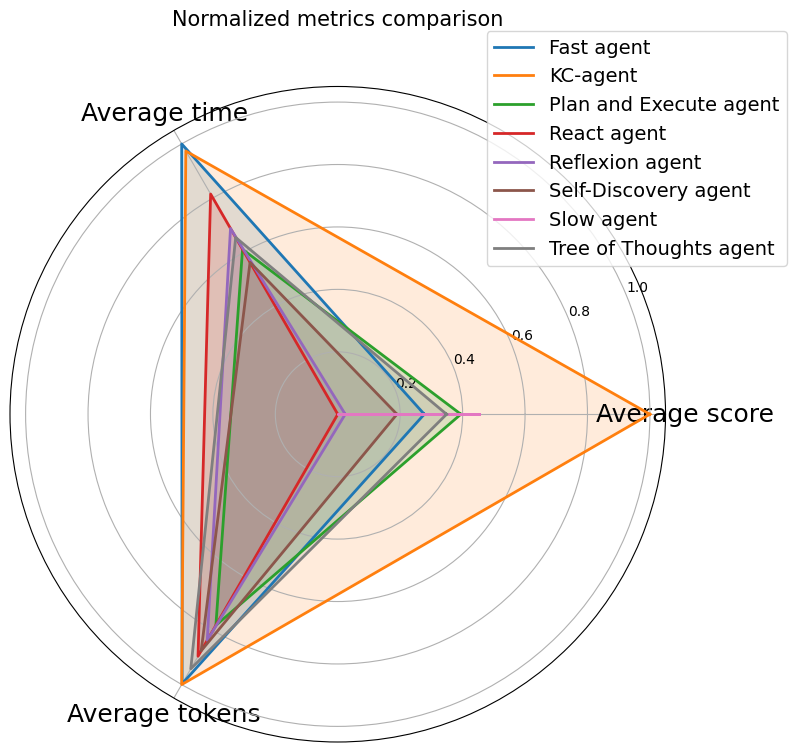

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Prepare Data for Radar Plot ---
custom_names = [
    'Fast agent',
    'KC-agent',
    'Plan and Execute agent',
    'React agent',
    'Reflexion agent',
    'Self-Discovery agent',
    'Slow agent',
    'Tree of Thoughts agent'
]
current_names = agg_df['agent'].unique()
print("Current agent names:", current_names)

# Create a mapping from current names to custom names
name_mapping = dict(zip(current_names, custom_names))
print("Mapping dictionary:", name_mapping)

# Replace the agent names in the DataFrame
agg_df['agent'] = agg_df['agent'].replace(name_mapping)

# Define the metrics for comparison.
# Here we use:
#   - 'avg_final_combined' as overall accuracy (beneficial: higher is better)
#   - 'avg_exec_time' as execution time (cost: lower is better)
#   - 'avg_tokens_used' as tokens used (cost: lower is better)
metrics = ['avg_final_combined', 'avg_exec_time', 'avg_tokens_used']

# Create a DataFrame with agent names and the selected metrics.
radar_df = agg_df[['agent'] + metrics].dropna()

# Normalize each metric:
# For beneficial metrics, use: (value - min) / (max - min)
# For cost metrics, use: (max - value) / (max - min)
norm_df = pd.DataFrame()
norm_df['agent'] = radar_df['agent']
for metric in metrics:
    min_val = radar_df[metric].min()
    max_val = radar_df[metric].max()
    if metric == 'avg_final_combined':  # Beneficial: higher is better
        norm_df[metric] = (radar_df[metric] - min_val) / (max_val - min_val)
    else:  # Cost metrics: lower is better -> invert normalization
        norm_df[metric] = (max_val - radar_df[metric]) / (max_val - min_val)

# --- Create Radar Plot ---
# Number of variables
N = len(metrics)
# Compute angle for each axis in the plot (in radians)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Set up the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each agent's normalized metrics on the radar chart
for idx, row in norm_df.iterrows():
    # Get values for each metric and complete the loop
    values = row[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['agent'], linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.15)

# Set custom category labels on the axes
custom_metric_labels = ["Average score", "Average time", "Average tokens"]
ax.set_thetagrids(np.degrees(angles[:-1]), custom_metric_labels, fontsize=18)

# Add title and legend
plt.title("Normalized metrics comparison", size=15, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=14)

plt.tight_layout()
output_dir = "paper_figures"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "radar_chart.pdf")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


In [45]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Select the metrics for the heatmap.
# # You can adjust this list with any other metrics you want to compare.
# metrics = ['avg_final_combined', 'avg_exec_time', 'avg_tokens_used']

# # Create a DataFrame for the heatmap.
# # Ensure that 'agent' is present in your aggregated DataFrame (agg_df).
# heatmap_df = agg_df[['agent'] + metrics].dropna().set_index('agent')

# # Normalize each metric using min–max normalization.
# norm_df = heatmap_df.copy()
# for col in metrics:
#     norm_df[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())

# # Plot the heatmap.
# plt.figure(figsize=(10, 6))
# sns.heatmap(norm_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white')
# plt.title("Heatmap of Normalized Metrics by Agent", fontsize=16)
# plt.ylabel("Agent", fontsize=12)
# plt.xlabel("Metric", fontsize=12)
# plt.tight_layout()
# plt.show()


In [13]:
agg_df

,agent,total_runs,successful_runs,success_rate,avg_final_new,std_final_new,se_final_new,min_final_new,max_final_new,avg_final_old,...,max_tokens_used,avg_iterations,std_iterations,se_iterations,min_iterations,max_iterations,improvement_per_token,improvement_per_second,avg_final_combined,se_final_combined
0,Fast agent,5,5,1.0,0.753333,0.096032,0.038413,0.633333,0.833333,0.847333,...,970,1.0,0.0,0.0,1,1,0.277230,0.011135,0.800333,0.021916
1,KC-agent,1,1,1.0,0.883333,NaN,0.000000,0.883333,0.883333,0.901667,...,613,1.0,NaN,0.0,1,1,0.271887,0.008500,0.892500,0.000000
2,Plan and Execute agent,3,3,1.0,0.816667,0.044096,0.020787,0.766667,0.850000,0.813889,...,13209,1.0,0.0,0.0,1,1,0.003694,0.000647,0.815278,0.026106
3,React agent,3,3,1.0,0.688889,0.164429,0.077513,0.500000,0.800000,0.841111,...,5069,1.0,0.0,0.0,1,1,-0.023262,-0.003123,0.765000,0.043502
4,Reflection agent,3,3,1.0,0.711111,0.134715,0.063505,0.566667,0.833333,0.825000,...,6421,1.0,0.0,0.0,1,1,-0.012148,-0.001858,0.768056,0.033487
5,Self-Discovery agent,3,3,1.0,0.825556,0.038921,0.018347,0.783333,0.860000,0.752778,...,5033,1.0,0.0,0.0,1,1,0.056786,0.005569,0.789167,0.032044
6,Slow agent,3,3,1.0,0.783222,0.132162,0.062302,0.633333,0.883000,0.861778,...,38762,1.0,0.0,0.0,1,1,0.002545,0.000973,0.822500,0.034490
7,Tree of Thoughts agent,3,3,1.0,0.766667,0.088192,0.041574,0.666667,0.833333,0.852222,...,2852,1.0,0.0,0.0,1,1,0.031937,0.001933,0.809444,0.025244


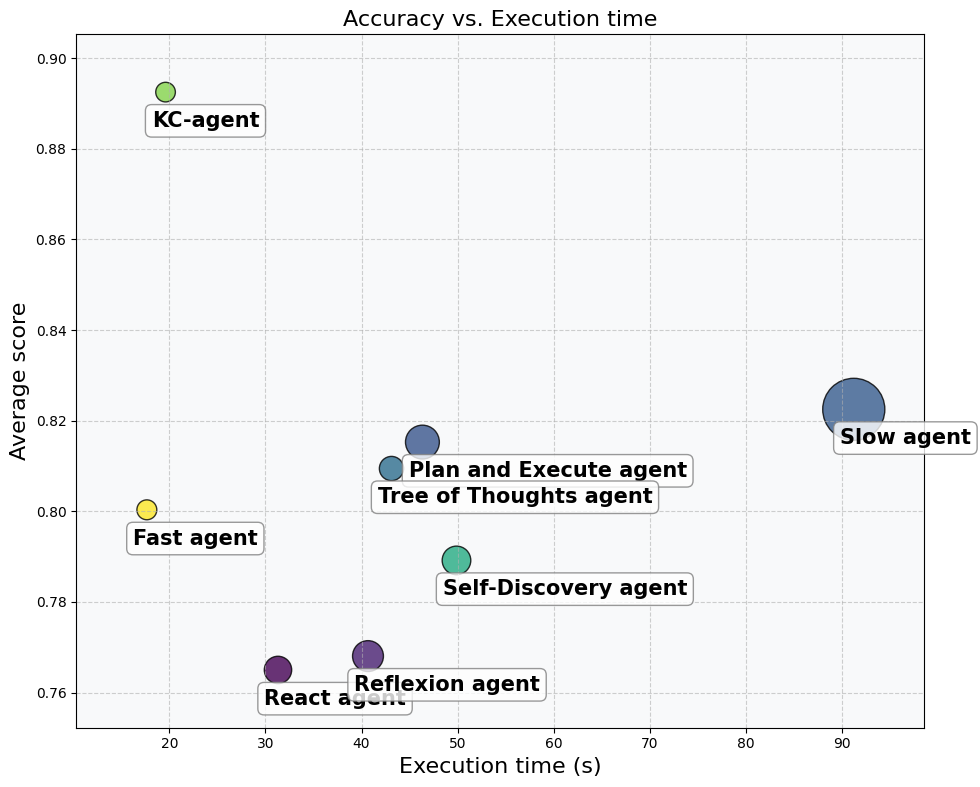

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from typing import Optional

def plot_bubble_performance(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create a refined bubble chart with:
      - X-axis: Execution Time (seconds)
      - Y-axis: Combined Accuracy
      - Bubble size: Tokens Used
      - Agent names annotated on each bubble (underscores escaped)
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame.
    output_dir : str, optional
        Directory to save the plot.
    """
    # custom_names = [
    #     'Fast',
    #     'Improver',
    #     'Plan and Execute',
    #     'React',
    #     'Reflection',
    #     'Self Discovery',
    #     'Slow',
    #     'Tree of Thoughts'
    # ]
    # current_names = agg_df['agent'].unique()
    # print("Current agent names:", current_names)

    # # Create a mapping from current names to custom names
    # name_mapping = dict(zip(current_names, custom_names))
    # print("Mapping dictionary:", name_mapping)

    # # Replace the agent names in the DataFrame
    # agg_df['agent'] = agg_df['agent'].replace(name_mapping)

    # Check required columns
    required = ['agent', 'avg_final_combined', 'avg_exec_time', 'avg_tokens_used']
    for col in required:
        if col not in agg_df.columns:
            warnings.warn(f"Column '{col}' is required but not found in the DataFrame.")
            return
    
    # Drop rows with missing values in required columns
    valid_df = agg_df.dropna(subset=required)
    if len(valid_df) < 2:
        warnings.warn("Not enough valid data points for the bubble chart.")
        return
    
    # Compute bubble sizes based on tokens used (normalize to a size range)
    tokens = valid_df['avg_tokens_used']
    min_tokens, max_tokens = tokens.min(), tokens.max()
    # Scale bubble sizes between 200 and 2000 (adjust as needed)
    bubble_size = ((tokens - min_tokens) / (max_tokens - min_tokens)) * 1800 + 200

    # Use a color gradient if 'improvement_per_second' exists; otherwise, use sequential colors.
    if 'improvement_per_second' in valid_df.columns:
        efficiency = valid_df['improvement_per_second']
        norm = plt.Normalize(efficiency.min(), efficiency.max())
        colors = plt.cm.viridis(norm(efficiency))
    else:
        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(valid_df)))
    
    # Create the bubble chart
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        valid_df['avg_exec_time'],
        valid_df['avg_final_combined'],
        s=bubble_size,
        c=colors,
        alpha=0.8,
        edgecolors='black',
        linewidths=1.0
    )
    
    # Annotate each bubble with the agent name (escape underscores)
    for i, row in valid_df.iterrows():
        agent_name = row['agent'].replace('_', '\\_')
        ax.annotate(
            agent_name,
            (row['avg_exec_time'], row['avg_final_combined']),
            xytext=(-10, -25),
            textcoords='offset points',
            fontsize=15,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    # Set axis labels and title
    ax.set_xlabel('Execution time (s)', fontsize=16)
    ax.set_ylabel('Average score', fontsize=16)
    ax.set_title('Accuracy vs. Execution time', fontsize=16)
    
    # Set axis limits with some padding
    x = valid_df['avg_exec_time']
    y = valid_df['avg_final_combined']
    x_padding = (x.max() - x.min()) * 0.1
    y_padding = (y.max() - y.min()) * 0.1
    ax.set_xlim(x.min() - x_padding, x.max() + x_padding)
    ax.set_ylim(y.min() - y_padding, y.max() + y_padding)
    
    # Aesthetics: add grid and set background color
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    
    # Save the figure if an output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "bubble_performance_vs_cost.pdf")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example usage:
plot_bubble_performance(agg_df, output_dir="paper_figures")
